<a href="https://colab.research.google.com/github/ngcheeyuan/Classification_projects/blob/main/09_skimlit_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skimlit:

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating can be found here : https://arxiv.org/abs/1710.06071

And the model architecture that they used to achieve their best results is available here : https://arxiv.org/abs/1612.05251

In [1]:
!nvidia-smi

Wed Jan 19 02:52:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data : 

https://github.com/Franck-Dernoncourt/pubmed-rct

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [22]:
#Start our experiments using the 20k dataset with numbers replaced with @ sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [23]:
import os
filenames =[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [55]:
#Create function to read the lines of a document

def get_lines(filename):
  '''
  Reads filename (a text filename) and returns the lines of text as a list
  
  Args:
    filename: a string containing the target file path.

  Returns:
    A list of strings with one string per line from the target filename.
  
  '''
  with open(filename,'r') as f:
    return f.readlines()

In [56]:
train_lines = get_lines(data_dir +'train.txt')

How I think our data should be best represented:

'''
'[{'line_number':0,

   'target' : 'BACKGROUND',

   'text' : 'Emotional eating is associated with overeating and the development of obesity .\n',

   'total_lines' : 11}]
'''

In [80]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like target label, the text of the sentence, how many sentencess
  are in the current abstract and what sentence number it is on.
  '''

  input_lines = get_lines(filename)# get all lines from filename
  abstract_lines = "" # creat an empty abstract
  abstract_samples = []

  #Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'): #check to see if this is an ID line
       abstract_id = line
       abstract_lines = "" #reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines()

      #Iterate through each line in a single abstract and count them at the same time

      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t') # split target label and text
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split)-1 # how many total lines are there in target abstract and start with 0
        abstract_samples.append(line_data)

    else: # if the above conditions aren't fulfilled the line contains a labelled sentence
      abstract_lines += line


  return abstract_samples


In [81]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

In [82]:
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [83]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [84]:
import pandas as pd

In [85]:
df_train = pd.DataFrame(train_samples)
df_val = pd.DataFrame(val_samples)
df_test = pd.DataFrame(test_samples)

In [86]:
df_train.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


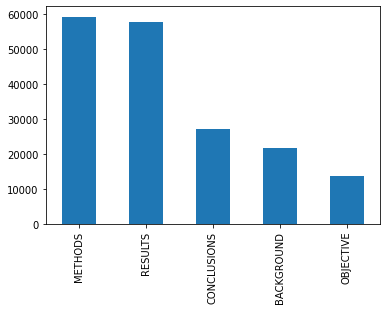

In [96]:
#distribution of labels in train data

df_train.target.value_counts().plot(kind = 'bar')

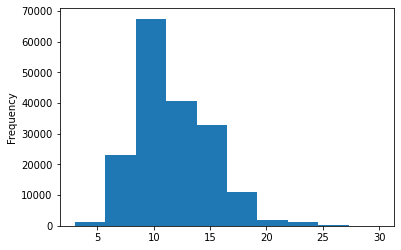

In [88]:
df_train.total_lines.plot.hist()

## Get lists of sentences

In [92]:
train_sentence = df_train['text'].tolist()
val_sentence = df_val['text'].tolist()
test_sentence = df_test['text'].tolist()

In [93]:
len(train_sentence), len(val_sentence),len(test_sentence)

(180040, 30212, 30135)